# Customer Analysis

Customer segmentation, loyalty impact, and high-value customer behavior during crisis period.

## Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('/home/parambrata-ghosh/Development/Personal/Projects/Food_Delivery_Startup/input/RPC_18_Datasets')
OUTPUT_DIR = Path('/home/parambrata-ghosh/Development/Personal/Projects/Food_Delivery_Startup/output')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load Data

In [2]:
df_customer = pd.read_csv(DATA_DIR / 'dim_customer.csv')
df_orders = pd.read_csv(DATA_DIR / 'fact_orders.csv')

df_orders['order_timestamp'] = pd.to_datetime(df_orders['order_timestamp'])
df_customer['signup_date'] = pd.to_datetime(df_customer['signup_date'], format='%d-%m-%Y')

df_orders['month'] = df_orders['order_timestamp'].dt.month
df_orders['year'] = df_orders['order_timestamp'].dt.year
df_orders['month_period'] = df_orders['order_timestamp'].dt.to_period('M')

# Filter only completed orders
df_orders_completed = df_orders[df_orders['is_cancelled'] == 'N']

print(f"Loaded {len(df_customer):,} customers and {len(df_orders):,} orders")
print(f"Completed orders: {len(df_orders_completed):,}")

Loaded 107,776 customers and 149,166 orders
Completed orders: 138,054


## Customer Segmentation

In [3]:
pre_crisis = df_orders_completed[(df_orders_completed['year'] == 2025) & (df_orders_completed['month'].between(1, 5))]
crisis = df_orders_completed[(df_orders_completed['year'] == 2025) & (df_orders_completed['month'].between(6, 9))]

customer_summary = df_orders_completed.groupby('customer_id').agg({
    'order_timestamp': ['min', 'max', 'count'],
    'total_amount': ['sum', 'mean'],
    'order_id': 'count'
}).reset_index()

customer_summary.columns = ['customer_id', 'first_order', 'last_order', 'total_orders', 'total_spent', 'avg_order_value', 'order_count']

# Add pre-crisis and crisis order counts
pre_crisis_counts = pre_crisis.groupby('customer_id').size().rename('pre_crisis_orders')
crisis_counts = crisis.groupby('customer_id').size().rename('crisis_orders')

customer_summary = customer_summary.merge(pre_crisis_counts, on='customer_id', how='left')
customer_summary = customer_summary.merge(crisis_counts, on='customer_id', how='left')
customer_summary['pre_crisis_orders'] = customer_summary['pre_crisis_orders'].fillna(0).astype(int)
customer_summary['crisis_orders'] = customer_summary['crisis_orders'].fillna(0).astype(int)

print("CUSTOMER SUMMARY STATISTICS")
print("=" * 60)
print(customer_summary[['total_orders', 'total_spent', 'avg_order_value', 'pre_crisis_orders', 'crisis_orders']].describe())

CUSTOMER SUMMARY STATISTICS
       total_orders   total_spent  avg_order_value  pre_crisis_orders  \
count  99790.000000  99790.000000     99790.000000        99790.00000   
mean       1.383445    486.633085       351.836167            1.07137   
std        0.647861    266.741557       108.436197            0.70325   
min        1.000000    115.060000       115.060000            0.00000   
25%        1.000000    295.840000       276.532500            1.00000   
50%        1.000000    401.520000       336.212500            1.00000   
75%        2.000000    615.400000       408.588333            1.00000   
max        7.000000   2715.180000       944.910000            6.00000   

       crisis_orders  
count   99790.000000  
mean        0.312075  
std         0.513742  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         4.000000  


## Q9: Loyalty Impact Analysis

In [4]:
# Identify loyal customers (5+ orders in pre-crisis period)
loyal_customers = customer_summary[customer_summary['pre_crisis_orders'] >= 5]['customer_id']

print(f"LOYAL CUSTOMER IDENTIFICATION")
print("=" * 60)
print(f"Total Loyal Customers (5+ pre-crisis orders): {len(loyal_customers):,}")

# Analyze loyalty retention
loyal_continued = customer_summary[(customer_summary['pre_crisis_orders'] >= 5) & (customer_summary['crisis_orders'] > 0)]
loyal_churned = customer_summary[(customer_summary['pre_crisis_orders'] >= 5) & (customer_summary['crisis_orders'] == 0)]

print(f"\nLoyalty Retention:")
print(f"  Continued Ordering: {len(loyal_continued):,} ({len(loyal_continued)/len(loyal_customers)*100:.1f}%)")
print(f"  Stopped Ordering: {len(loyal_churned):,} ({len(loyal_churned)/len(loyal_customers)*100:.1f}%)")

# Order frequency comparison for loyal customers who continued
loyal_continued['order_frequency_change'] = (
    (loyal_continued['crisis_orders'] / 4) - (loyal_continued['pre_crisis_orders'] / 5)
)
loyal_continued['order_frequency_change_pct'] = (
    loyal_continued['order_frequency_change'] / (loyal_continued['pre_crisis_orders'] / 5) * 100
)

print(f"\nLoyal Customers Who Continued:")
print(f"  Avg Pre-Crisis Orders/Month: {(loyal_continued['pre_crisis_orders'] / 5).mean():.2f}")
print(f"  Avg Crisis Orders/Month: {(loyal_continued['crisis_orders'] / 4).mean():.2f}")
print(f"  Avg Frequency Change: {loyal_continued['order_frequency_change_pct'].mean():.1f}%")

LOYAL CUSTOMER IDENTIFICATION
Total Loyal Customers (5+ pre-crisis orders): 50

Loyalty Retention:
  Continued Ordering: 8 (16.0%)
  Stopped Ordering: 42 (84.0%)

Loyal Customers Who Continued:
  Avg Pre-Crisis Orders/Month: 1.02
  Avg Crisis Orders/Month: 0.28
  Avg Frequency Change: -72.4%


In [5]:
# Analyze churned loyal customers
loyal_churned_profile = loyal_churned.merge(df_customer[['customer_id', 'city', 'acquisition_channel']], on='customer_id')

print(f"\nCHURNED LOYAL CUSTOMER PROFILE")
print("=" * 60)
print(f"\nBy City:")
print(loyal_churned_profile['city'].value_counts().to_string())

print(f"\nBy Acquisition Channel:")
print(loyal_churned_profile['acquisition_channel'].value_counts().to_string())

print(f"\nAverage Spending (Lost Revenue):")
print(f"  Total Spent by Churned Loyal: ₹{loyal_churned['total_spent'].sum():,.2f}")
print(f"  Avg Spent per Customer: ₹{loyal_churned['total_spent'].mean():,.2f}")


CHURNED LOYAL CUSTOMER PROFILE

By City:
city
Pune         9
Chennai      7
Delhi        7
Bengaluru    6
Kolkata      5
Mumbai       5
Hyderabad    3

By Acquisition Channel:
acquisition_channel
Organic     22
Paid         9
Referral     7
Social       4

Average Spending (Lost Revenue):
  Total Spent by Churned Loyal: ₹75,182.05
  Avg Spent per Customer: ₹1,790.05


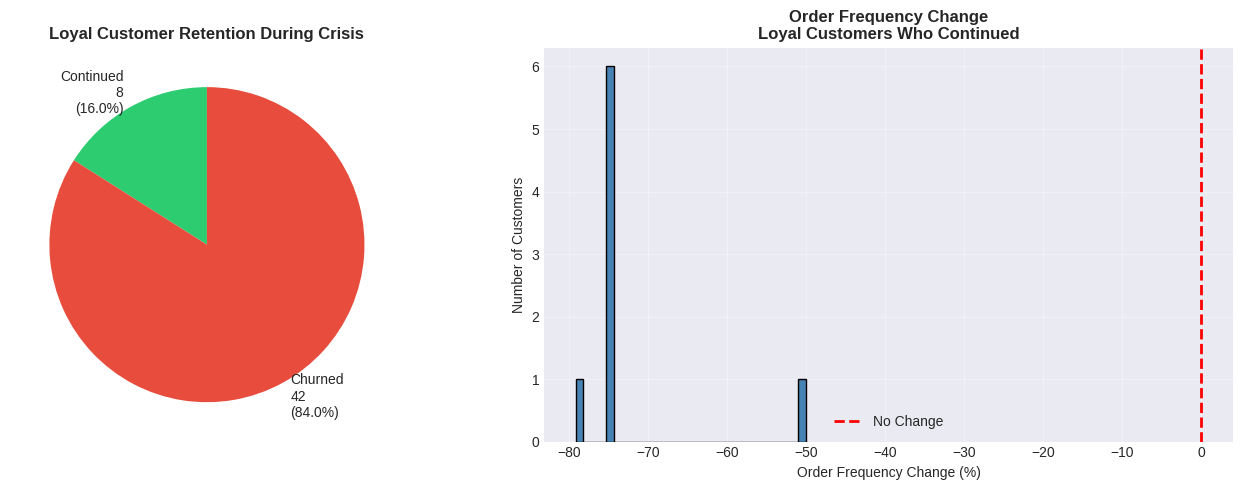

In [6]:
# Visualize loyalty impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loyalty retention pie chart
loyalty_data = [len(loyal_continued), len(loyal_churned)]
labels = [f'Continued\n{len(loyal_continued):,}\n({len(loyal_continued)/len(loyal_customers)*100:.1f}%)', 
          f'Churned\n{len(loyal_churned):,}\n({len(loyal_churned)/len(loyal_customers)*100:.1f}%)']
colors = ['#2ecc71', '#e74c3c']
ax1.pie(loyalty_data, labels=labels, colors=colors, autopct='', startangle=90)
ax1.set_title('Loyal Customer Retention During Crisis', fontweight='bold')

# Order frequency change distribution
ax2.hist(loyal_continued['order_frequency_change_pct'].dropna(), bins=30, color='steelblue', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Change')
ax2.set_xlabel('Order Frequency Change (%)')
ax2.set_ylabel('Number of Customers')
ax2.set_title('Order Frequency Change\nLoyal Customers Who Continued', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Q10: High-Value Customer Analysis

In [7]:
# Identify top 5% customers by spending
spending_threshold = customer_summary['total_spent'].quantile(0.95)
high_value_customers = customer_summary[customer_summary['total_spent'] >= spending_threshold]

print(f"HIGH-VALUE CUSTOMER IDENTIFICATION")
print("=" * 60)
print(f"Top 5% Spending Threshold: ₹{spending_threshold:,.2f}")
print(f"Number of High-Value Customers: {len(high_value_customers):,}")
print(f"Total Spent by HVC: ₹{high_value_customers['total_spent'].sum():,.2f}")
print(f"Avg Spent per HVC: ₹{high_value_customers['total_spent'].mean():,.2f}")
print(f"Revenue Contribution: {high_value_customers['total_spent'].sum()/customer_summary['total_spent'].sum()*100:.1f}%")

# Pre-crisis vs crisis behavior
hvc_pre_crisis_orders = high_value_customers['pre_crisis_orders'].sum()
hvc_crisis_orders = high_value_customers['crisis_orders'].sum()
hvc_order_change = (hvc_crisis_orders - hvc_pre_crisis_orders) / hvc_pre_crisis_orders * 100

print(f"\nHVC ORDER BEHAVIOR")
print("=" * 60)
print(f"Pre-Crisis Orders: {hvc_pre_crisis_orders:,}")
print(f"Crisis Orders: {hvc_crisis_orders:,}")
print(f"Order Change: {hvc_order_change:+.1f}%")

HIGH-VALUE CUSTOMER IDENTIFICATION
Top 5% Spending Threshold: ₹1,020.85
Number of High-Value Customers: 4,990
Total Spent by HVC: ₹6,196,320.62
Avg Spent per HVC: ₹1,241.75
Revenue Contribution: 12.8%

HVC ORDER BEHAVIOR
Pre-Crisis Orders: 11,613
Crisis Orders: 3,383
Order Change: -70.9%


In [8]:
# HVC retention analysis
hvc_continued = high_value_customers[high_value_customers['crisis_orders'] > 0]
hvc_churned = high_value_customers[high_value_customers['crisis_orders'] == 0]

print(f"\nHVC RETENTION")
print("=" * 60)
print(f"Continued: {len(hvc_continued):,} ({len(hvc_continued)/len(high_value_customers)*100:.1f}%)")
print(f"Churned: {len(hvc_churned):,} ({len(hvc_churned)/len(high_value_customers)*100:.1f}%)")
print(f"Lost Revenue from Churned HVC: ₹{hvc_churned['total_spent'].sum():,.2f}")

# Compare HVC vs regular customers behavior
regular_customers = customer_summary[customer_summary['total_spent'] < spending_threshold]
regular_continued = regular_customers[regular_customers['crisis_orders'] > 0]

hvc_retention_rate = len(hvc_continued) / len(high_value_customers) * 100
regular_retention_rate = len(regular_continued) / len(regular_customers) * 100

print(f"\nRETENTION COMPARISON")
print("=" * 60)
print(f"HVC Retention Rate: {hvc_retention_rate:.1f}%")
print(f"Regular Customer Retention Rate: {regular_retention_rate:.1f}%")
print(f"Difference: {hvc_retention_rate - regular_retention_rate:+.1f} pp")


HVC RETENTION
Continued: 2,625 (52.6%)
Churned: 2,365 (47.4%)
Lost Revenue from Churned HVC: ₹2,889,160.73

RETENTION COMPARISON
HVC Retention Rate: 52.6%
Regular Customer Retention Rate: 27.6%
Difference: +25.0 pp


In [9]:
# Analyze HVC spending patterns
hvc_orders = df_orders_completed[df_orders_completed['customer_id'].isin(high_value_customers['customer_id'])]
hvc_orders['period'] = hvc_orders['month'].apply(lambda x: 'Pre-Crisis' if x <= 5 else 'Crisis')

hvc_aov = hvc_orders.groupby('period')['total_amount'].mean()

print(f"\nHVC SPENDING PATTERNS")
print("=" * 60)
print(f"Pre-Crisis AOV: ₹{hvc_aov.get('Pre-Crisis', 0):,.2f}")
print(f"Crisis AOV: ₹{hvc_aov.get('Crisis', 0):,.2f}")
if 'Pre-Crisis' in hvc_aov.index and 'Crisis' in hvc_aov.index:
    aov_change = (hvc_aov['Crisis'] - hvc_aov['Pre-Crisis']) / hvc_aov['Pre-Crisis'] * 100
    print(f"AOV Change: {aov_change:+.1f}%")


HVC SPENDING PATTERNS
Pre-Crisis AOV: ₹414.16
Crisis AOV: ₹409.91
AOV Change: -1.0%


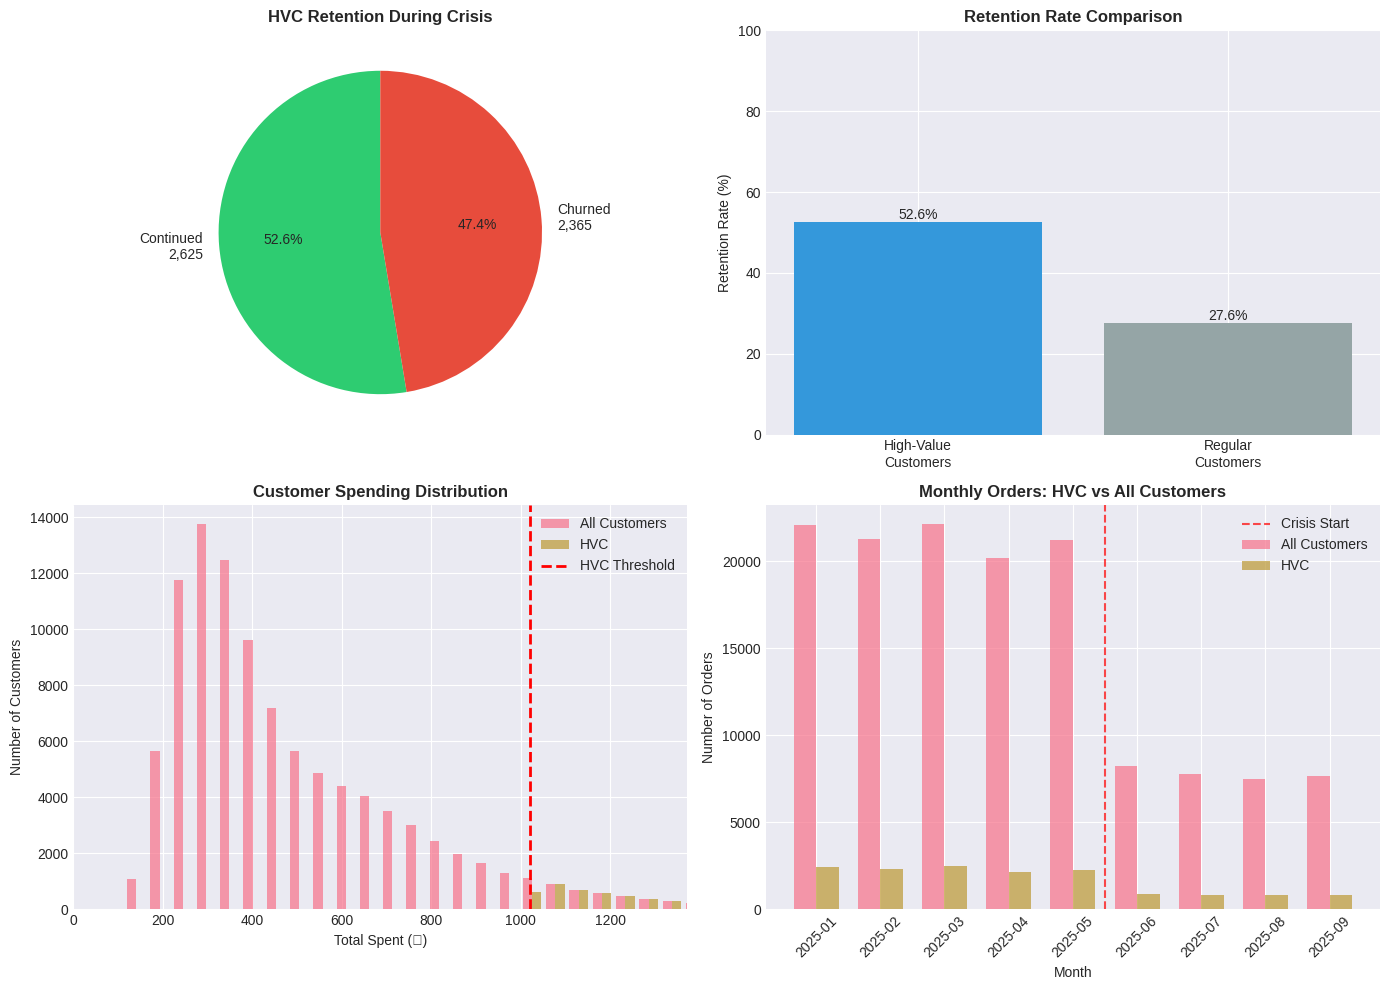

In [10]:
# Visualize HVC analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# HVC retention
hvc_retention_data = [len(hvc_continued), len(hvc_churned)]
labels = [f'Continued\n{len(hvc_continued):,}', f'Churned\n{len(hvc_churned):,}']
axes[0, 0].pie(hvc_retention_data, labels=labels, colors=['#2ecc71', '#e74c3c'], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('HVC Retention During Crisis', fontweight='bold')

# Retention comparison
categories = ['High-Value\nCustomers', 'Regular\nCustomers']
retention_rates = [hvc_retention_rate, regular_retention_rate]
bars = axes[0, 1].bar(categories, retention_rates, color=['#3498db', '#95a5a6'])
axes[0, 1].set_ylabel('Retention Rate (%)')
axes[0, 1].set_title('Retention Rate Comparison', fontweight='bold')
axes[0, 1].set_ylim(0, 100)
for bar, rate in zip(bars, retention_rates):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{rate:.1f}%', ha='center', va='bottom')

# Spending distribution
axes[1, 0].hist([customer_summary['total_spent'], high_value_customers['total_spent']], 
                bins=50, label=['All Customers', 'HVC'], alpha=0.7)
axes[1, 0].axvline(x=spending_threshold, color='red', linestyle='--', linewidth=2, label='HVC Threshold')
axes[1, 0].set_xlabel('Total Spent (₹)')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].set_title('Customer Spending Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, customer_summary['total_spent'].quantile(0.99))

# Monthly orders: HVC vs All
monthly_hvc = hvc_orders.groupby('month_period').size()
monthly_all = df_orders_completed.groupby('month_period').size()
months = [str(m) for m in monthly_all.index]
x = np.arange(len(months))
width = 0.35

axes[1, 1].bar(x - width/2, monthly_all.values, width, label='All Customers', alpha=0.7)
axes[1, 1].bar(x + width/2, monthly_hvc.values, width, label='HVC', alpha=0.7)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Orders')
axes[1, 1].set_title('Monthly Orders: HVC vs All Customers', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(months, rotation=45)
axes[1, 1].axvline(x=4.5, color='red', linestyle='--', alpha=0.7, label='Crisis Start')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## RFM Analysis

In [11]:
# RFM (Recency, Frequency, Monetary) Analysis
analysis_date = df_orders['order_timestamp'].max()

rfm = df_orders_completed.groupby('customer_id').agg({
    'order_timestamp': lambda x: (analysis_date - x.max()).days,
    'order_id': 'count',
    'total_amount': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Create RFM scores (1-5, 5 being best)
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

# Segment customers
def segment_customer(row):
    if row['r_score'] >= 4 and row['f_score'] >= 4:
        return 'Champions'
    elif row['r_score'] >= 4 and row['f_score'] >= 3:
        return 'Loyal'
    elif row['r_score'] >= 3 and row['f_score'] >= 3:
        return 'Potential Loyalists'
    elif row['r_score'] >= 4 and row['f_score'] <= 2:
        return 'New Customers'
    elif row['r_score'] <= 2 and row['f_score'] >= 4:
        return 'At Risk'
    elif row['r_score'] <= 2 and row['f_score'] <= 2:
        return 'Lost'
    else:
        return 'Others'

rfm['segment'] = rfm.apply(segment_customer, axis=1)

print("RFM CUSTOMER SEGMENTATION")
print("=" * 60)
print(rfm['segment'].value_counts().to_string())

segment_summary = rfm.groupby('segment').agg({
    'customer_id': 'count',
    'monetary': 'sum',
    'frequency': 'mean',
    'recency': 'mean'
}).round(2)
segment_summary.columns = ['count', 'total_revenue', 'avg_frequency', 'avg_recency']

print(f"\nSEGMENT SUMMARY")
print("=" * 60)
print(segment_summary.to_string())

RFM CUSTOMER SEGMENTATION
segment
Champions              20686
Lost                   19083
Others                 17541
New Customers          13050
Potential Loyalists    12085
At Risk                10899
Loyal                   6446

SEGMENT SUMMARY
                     count  total_revenue  avg_frequency  avg_recency
segment                                                              
At Risk              10899     6390516.55           1.66       217.12
Champions            20686    15427309.73           2.12        77.47
Lost                 19083     6726848.20           1.00       226.70
Loyal                 6446     2259786.59           1.00        83.76
New Customers        13050     4589389.41           1.00        82.79
Others               17541     6151936.82           1.00       197.45
Potential Loyalists  12085     7015328.26           1.65       160.41


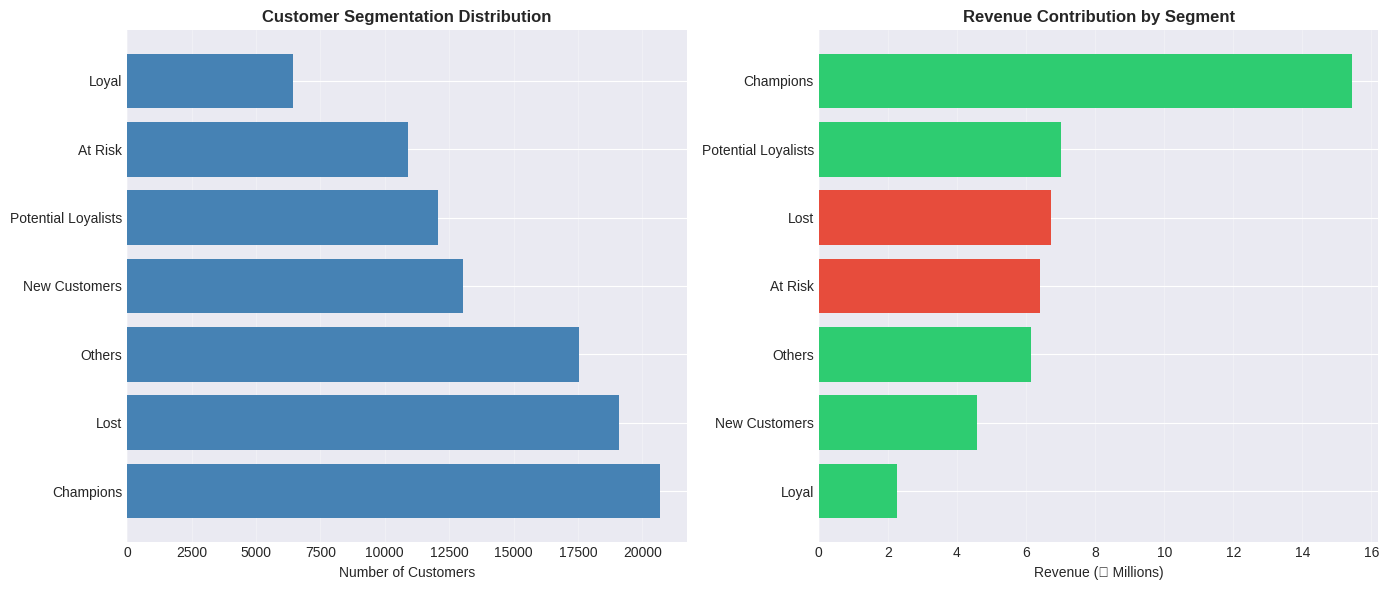

In [12]:
# Visualize RFM segments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Segment distribution
segment_counts = rfm['segment'].value_counts()
ax1.barh(segment_counts.index, segment_counts.values, color='steelblue')
ax1.set_xlabel('Number of Customers')
ax1.set_title('Customer Segmentation Distribution', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Revenue by segment
segment_revenue = rfm.groupby('segment')['monetary'].sum().sort_values()
colors_revenue = ['#e74c3c' if 'Lost' in seg or 'At Risk' in seg else '#2ecc71' for seg in segment_revenue.index]
ax2.barh(segment_revenue.index, segment_revenue.values/1000000, color=colors_revenue)
ax2.set_xlabel('Revenue (₹ Millions)')
ax2.set_title('Revenue Contribution by Segment', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Acquisition Channel Performance

In [13]:
# Merge customer acquisition data
df_orders_acquisition = df_orders_completed.merge(df_customer[['customer_id', 'acquisition_channel']], on='customer_id')
df_orders_acquisition['period'] = df_orders_acquisition['month'].apply(lambda x: 'Pre-Crisis' if x <= 5 else 'Crisis')

channel_performance = df_orders_acquisition.groupby(['acquisition_channel', 'period']).size().unstack(fill_value=0)
channel_performance['total'] = channel_performance.sum(axis=1)
channel_performance['change_pct'] = ((channel_performance['Crisis'] - channel_performance['Pre-Crisis']) / 
                                      channel_performance['Pre-Crisis'] * 100)

print("ACQUISITION CHANNEL PERFORMANCE")
print("=" * 80)
print(channel_performance.to_string())

# Revenue by channel
channel_revenue = df_orders_acquisition.groupby(['acquisition_channel', 'period'])['total_amount'].sum().unstack(fill_value=0)
channel_revenue['change_pct'] = ((channel_revenue['Crisis'] - channel_revenue['Pre-Crisis']) / 
                                  channel_revenue['Pre-Crisis'] * 100)

print(f"\nREVENUE BY CHANNEL")
print("=" * 80)
print(channel_revenue.to_string())

ACQUISITION CHANNEL PERFORMANCE
period               Crisis  Pre-Crisis  total  change_pct
acquisition_channel                                       
Organic               13582       59053  72635  -77.000322
Paid                   9917       21314  31231  -53.471896
Referral               4020       15946  19966  -74.789916
Social                 3623       10599  14222  -65.817530

REVENUE BY CHANNEL
period                   Crisis   Pre-Crisis  change_pct
acquisition_channel                                     
Organic              4769568.41  20756406.14  -77.021222
Paid                 3490667.14   7494738.64  -53.425098
Referral             1407935.57   5620788.72  -74.951281
Social               1271980.19   3749030.75  -66.071759


## Key Insights Summary

In [14]:
print("\n" + "=" * 80)
print("CUSTOMER ANALYSIS - EXECUTIVE SUMMARY")
print("=" * 80)

print(f"\n📊 LOYALTY IMPACT")
print(f"  • Loyal Customers (5+ pre-crisis orders): {len(loyal_customers):,}")
print(f"  • Retention Rate: {len(loyal_continued)/len(loyal_customers)*100:.1f}%")
print(f"  • Churned: {len(loyal_churned):,} customers")
print(f"  • Lost Revenue from Churned Loyal: ₹{loyal_churned['total_spent'].sum():,.2f}")

print(f"\n💎 HIGH-VALUE CUSTOMERS (Top 5%)")
print(f"  • Number of HVCs: {len(high_value_customers):,}")
print(f"  • Revenue Contribution: {high_value_customers['total_spent'].sum()/customer_summary['total_spent'].sum()*100:.1f}%")
print(f"  • HVC Retention: {len(hvc_continued)/len(high_value_customers)*100:.1f}%")
print(f"  • Regular Customer Retention: {regular_retention_rate:.1f}%")
print(f"  • Order Change: {hvc_order_change:+.1f}%")

print(f"\n🎯 RFM SEGMENTATION")
print(f"  • Champions: {len(rfm[rfm['segment']=='Champions']):,}")
print(f"  • At Risk: {len(rfm[rfm['segment']=='At Risk']):,}")
print(f"  • Lost: {len(rfm[rfm['segment']=='Lost']):,}")

print(f"\n📱 ACQUISITION CHANNELS")
most_affected_channel = channel_performance['change_pct'].idxmin()
least_affected_channel = channel_performance['change_pct'].idxmax()
print(f"  • Most Affected: {most_affected_channel} ({channel_performance.loc[most_affected_channel, 'change_pct']:.1f}%)")
print(f"  • Best Performing: {least_affected_channel} ({channel_performance.loc[least_affected_channel, 'change_pct']:.1f}%)")

print("\n" + "=" * 80)


CUSTOMER ANALYSIS - EXECUTIVE SUMMARY

📊 LOYALTY IMPACT
  • Loyal Customers (5+ pre-crisis orders): 50
  • Retention Rate: 16.0%
  • Churned: 42 customers
  • Lost Revenue from Churned Loyal: ₹75,182.05

💎 HIGH-VALUE CUSTOMERS (Top 5%)
  • Number of HVCs: 4,990
  • Revenue Contribution: 12.8%
  • HVC Retention: 52.6%
  • Regular Customer Retention: 27.6%
  • Order Change: -70.9%

🎯 RFM SEGMENTATION
  • Champions: 20,686
  • At Risk: 10,899
  • Lost: 19,083

📱 ACQUISITION CHANNELS
  • Most Affected: Organic (-77.0%)
  • Best Performing: Paid (-53.5%)



## Export for Dashboard

In [15]:
OUTPUT_DIR.mkdir(exist_ok=True)

# Export customer segments
customer_summary.to_csv(OUTPUT_DIR / 'customer_summary.csv', index=False)
rfm.to_csv(OUTPUT_DIR / 'customer_rfm_segments.csv', index=False)
channel_performance.to_csv(OUTPUT_DIR / 'acquisition_channel_performance.csv')
loyal_churned_profile.to_csv(OUTPUT_DIR / 'churned_loyal_customers.csv', index=False)
high_value_customers.to_csv(OUTPUT_DIR / 'high_value_customers.csv', index=False)

print("Exported files for dashboard:")
print("  • customer_summary.csv")
print("  • customer_rfm_segments.csv")
print("  • acquisition_channel_performance.csv")
print("  • churned_loyal_customers.csv")
print("  • high_value_customers.csv")

Exported files for dashboard:
  • customer_summary.csv
  • customer_rfm_segments.csv
  • acquisition_channel_performance.csv
  • churned_loyal_customers.csv
  • high_value_customers.csv
